# MNIST Digit Classification

This notebook discusses existing solutions to the elementary computer vision problem MNIST digit classification.

The MNIST dataset is a large collection of handwritten digits on the range of zero to nine inclusive (Class Range = [0, 9]). The dataset is primarily used as an introduction to classification algorithms, deep learning, and computer vision. Each image is a 28x28 pixel black and white image where each pixel is an intensity from zero to 255 (Color Range = [0, 255]).

In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# A method that plots a confusion matrix nicely
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize: plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      else: plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Data Preparation

The dataset is broken into four objects packaged in two tuples: (x_train, y_train) and (x_test, y_test). `x` refers to the input dataset, or the images. `y` refers to the label dataset, or the classifications.

While each image is ready to be used, most algorithms benefit or require the data to be transformed into an acceptable format. Typically, algorithms look at three main attributes to determine if a dataset is properly formatted:
* Shape
* Data Type
* Range

The original **shape** of each image is `(28, 28)` and the collective dataset's shape is `(n, 28, 28)` where `n` is the number of entries in the dataset. Because the images come as two-dimensional objects, some algorithms will not be able to process the data. Thus, the images will need to be **flattened** into the new shape `(784)`, which is one-dimensional. Some algorithms may require an additional reshaping to accomodate their algorithm, such as TensorFlow's Conv2D layer requires an array encapsulating all two-dimensional images for that datapoint.

The **data type** of the dataset is extremely important as algorithms expect the inputs to come as a specific type. Incorrect data types will lead to errors and incorrect calculations. This notebook's only data type transformation is to ensure all pixel intensities are `float32` variables. The classification data is also encoded into categorical features using [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

The **range** of the dataset refers to the distance between min and max value. For many algorithms, especially deep learning, the dataset is expected to be normalized meaning the dataset's range is [0, 1]. For this notebook, each pixel's intensity is stored on the range [0, 255]. To normalize each image, we must divide all pixel intensities by 255.

In [ ]:
# Load the raw data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
# Reshape the training data
input_shape = list(x_train.shape)
input_shape.append(1)
x_train = x_train.reshape(input_shape)

In [ ]:
# Reshape the testing data
input_shape = list(x_test.shape)
input_shape.append(1)
x_test = x_test.reshape(input_shape)

In [ ]:
# Retype the datasets
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
# Scale the datasets to be on range [0,1.0]
x_train /= 255
x_test /= 255

In [ ]:
# Make the classification dataset categorical
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

The flattened version of the categorical classifications will undo the encoding and represent the explicit digit classification on the range [0, 9].

In [ ]:
# Create a flat version of the datasets
x_train_flat = np.array([x.flatten() for x in x_train])
x_test_flat = np.array([x.flatten() for x in x_test])
y_train_flat = np.array([np.argmax(y) for y in y_train])
y_test_flat = np.array([np.argmax(y) for y in y_test])

In [ ]:
print("x_train shape: {}".format(x_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


### Model: TensorFlow Convolutional Neural Network

A live demo of this neural network can be [visualized using Keras.*js*](https://transcranial.github.io/keras-js/#/mnist-cnn). This tool allows you to draw your own digits, see the realtime classification, and take a look into the neural network and see what it sees.

TensorFlow openly supports and directs new users of their library to the MNIST digit classification problem. It serves as a great project to get familiar with using TensorFlow objects and methods. This section discusses a basic convolutional neural network built and trained using TensorFlow. 

Convolutional Neural Networks (CNNs) are a deep learning algorithm designed to tackle image analysis, specifically recognition and classification. The network relies on various layers of **convolutions** and **poolings** to extract features. These extracted features determine the classification of the digit. The CNN used in this notebook relies on implicit convolution, as we are not explicitly defining the features our convolutional algorithm is calculating. 

Other convolutional neural networks may rely on explicit convolutional algorithms to calculate features that are too difficult to implicitly learn, but those explicit convolutional algorithms tend to become independent projects.

In [ ]:
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential

In [ ]:
# Create TensorFlow model
convnet = Sequential()

# Add 2 Convolutional layers, a Pooling layer, and a Dense network at the bottom
convnet.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
convnet.add(Activation('relu'))
convnet.add(Conv2D(32, (3, 3)))
convnet.add(Activation('relu'))
convnet.add(MaxPooling2D(pool_size=(2, 2)))
convnet.add(Dropout(0.25))
convnet.add(Flatten())
convnet.add(Dense(128))
convnet.add(Activation('relu'))
convnet.add(Dropout(0.5))
convnet.add(Dense(10))
convnet.add(Activation('softmax'))

# Compile with categorical crossentropy as this is a multi-label classification problem
convnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tfa.metrics.F1Score(num_classes=10)])

In [ ]:
convnet_history = convnet.fit(x_train, y_train, batch_size=128, epochs=100, verbose=2, validation_data=(x_test, y_test))

Epoch 1/100
469/469 - 92s - loss: 0.2865 - accuracy: 0.9129 - f1_score: 0.9120 - val_loss: 0.0587 - val_accuracy: 0.9812 - val_f1_score: 0.9812
Epoch 2/100
469/469 - 91s - loss: 0.0957 - accuracy: 0.9721 - f1_score: 0.9718 - val_loss: 0.0393 - val_accuracy: 0.9877 - val_f1_score: 0.9876
Epoch 3/100
469/469 - 93s - loss: 0.0721 - accuracy: 0.9782 - f1_score: 0.9780 - val_loss: 0.0420 - val_accuracy: 0.9868 - val_f1_score: 0.9866
Epoch 4/100
469/469 - 94s - loss: 0.0626 - accuracy: 0.9808 - f1_score: 0.9806 - val_loss: 0.0297 - val_accuracy: 0.9900 - val_f1_score: 0.9899
Epoch 5/100
469/469 - 97s - loss: 0.0497 - accuracy: 0.9849 - f1_score: 0.9847 - val_loss: 0.0297 - val_accuracy: 0.9904 - val_f1_score: 0.9903
Epoch 6/100
469/469 - 98s - loss: 0.0475 - accuracy: 0.9852 - f1_score: 0.9851 - val_loss: 0.0336 - val_accuracy: 0.9889 - val_f1_score: 0.9888
Epoch 7/100
469/469 - 97s - loss: 0.0439 - accuracy: 0.9860 - f1_score: 0.9859 - val_loss: 0.0260 - val_accuracy: 0.9918 - val_f1_score:

In [ ]:
# Create predictions using the CNN
convnet_pred = convnet.predict(x_test, batch_size=128)
convnet_pred_flat = np.argmax(convnet_pred, axis=1)

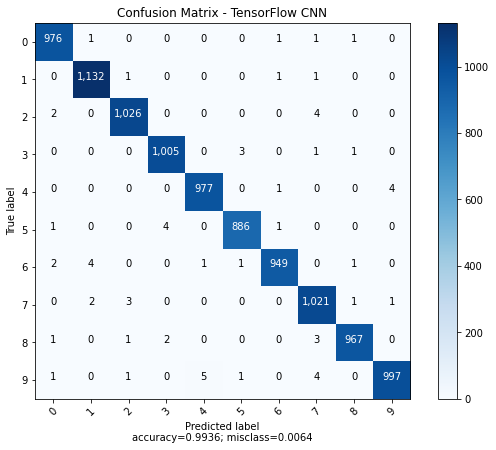

In [ ]:
# CNN confusion matrix
cm = tf.math.confusion_matrix(y_test_flat, convnet_pred_flat, num_classes=10)
plot_confusion_matrix(cm=cm.numpy(), target_names=range(10), normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix - TensorFlow CNN')
plt.show()

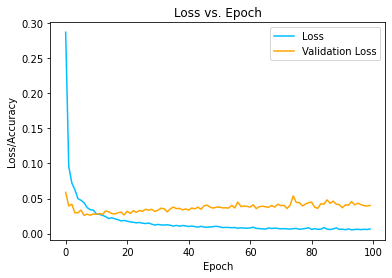

In [ ]:
# Plot the loss for the training and validation
plt.plot(convnet_history.history['loss'], label='Loss', c='deepskyblue') 
plt.plot(convnet_history.history['val_loss'], label='Validation Loss', c='orange') 
plt.title('Loss vs. Epoch')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

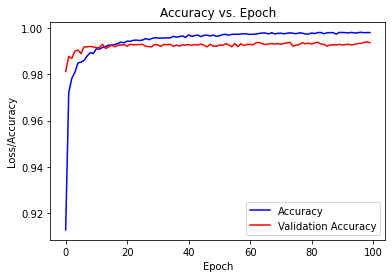

In [ ]:
# Plot the accuracy for the training and validation
plt.plot(convnet_history.history['accuracy'], label='Accuracy', c='blue') 
plt.plot(convnet_history.history['val_accuracy'], label='Validation Accuracy', c='red') 
plt.title('Accuracy vs. Epoch')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

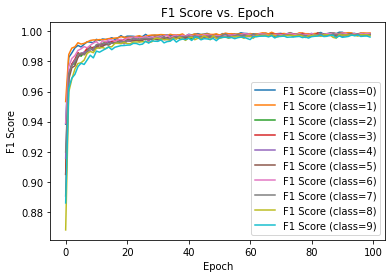

In [ ]:
# Plot the F1 Score for the training data
f1_transpose = np.array(convnet_history.history['f1_score']).transpose()
for i, c in enumerate(f1_transpose):
  plt.plot(c, label='F1 Score (class={})'.format(i))
plt.title('F1 Score vs. Epoch')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend()
plt.show()

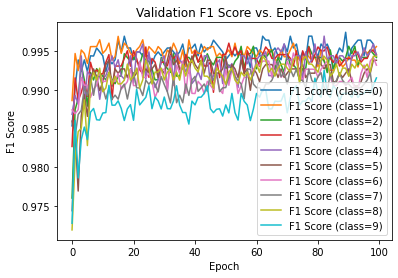

In [ ]:
# Plot the F1 Score for the validation data
f1_transpose = np.array(convnet_history.history['val_f1_score']).transpose()
for i, c in enumerate(f1_transpose):
  plt.plot(c, label='F1 Score (class={})'.format(i))
plt.title('Validation F1 Score vs. Epoch')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Model: Random Forest Classification

Random Forest Classification is a specialized algorithm designed to tackle multi-label classification problems by creating a vast "forest" of `n` decision trees. A decision tree is a flowchart-esque model where an input starts at the root of the tree, processes the current node's decision using the input, and the progress to the specific child node depending on the decision's result until a predicted classification is given.

![](https://i.imgur.com/DYxQmRb.png)

This notebook creates a variety of random forests each with a different number of trees (n=1,10,25,...). A confusion matrix will be generated to determine the performance of the random forest algorithm for each given `n`.

In [ ]:
# Create forests with a variety of trees
n = [1,10,25,50,100,250,1000,10000] # The different random forests and their respective n
forests = {}
for i in n:
  forests[i] = RandomForestClassifier(n_estimators=i, random_state=0)
  forests[i].fit(x_train_flat, y_train_flat)

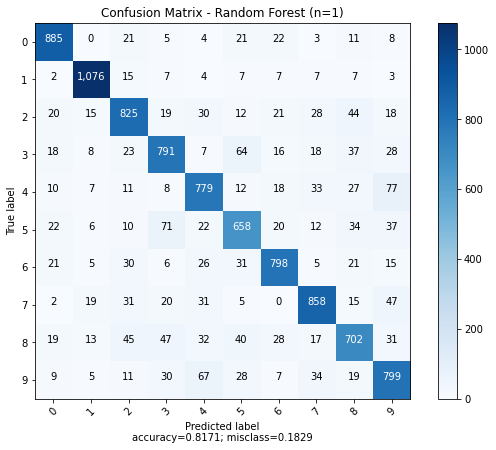

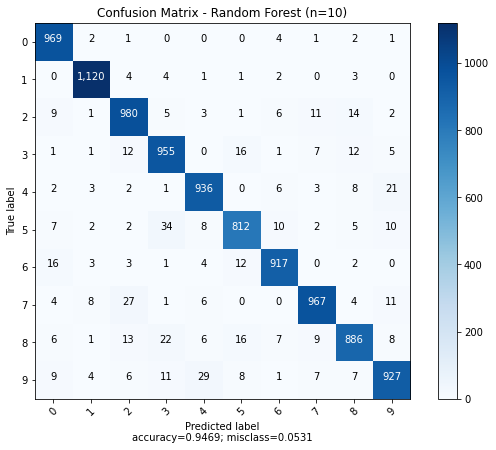

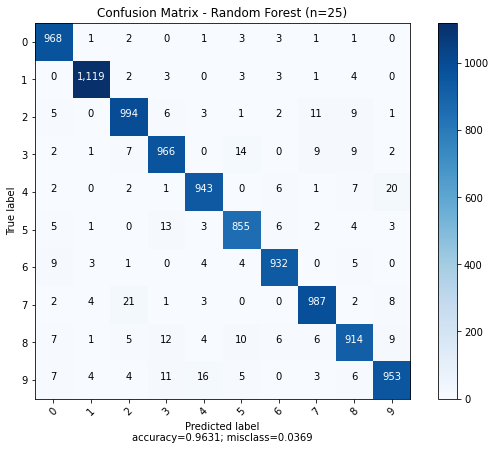

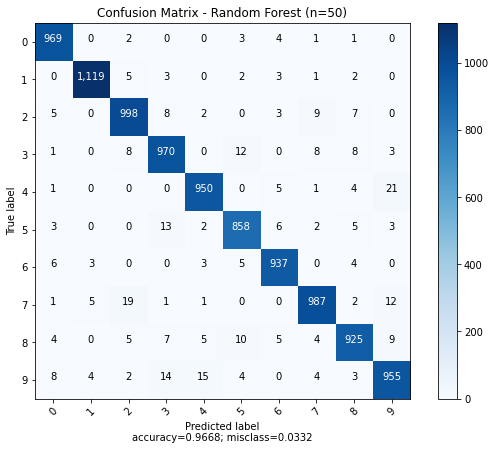

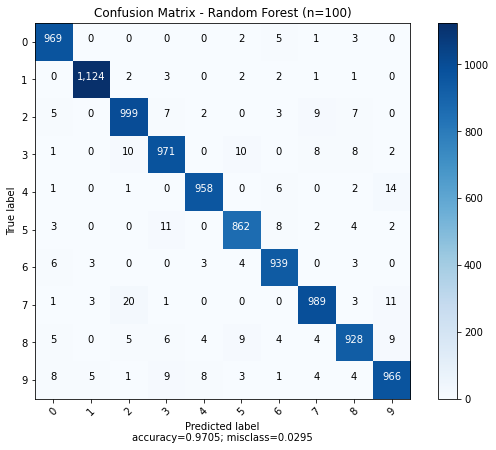

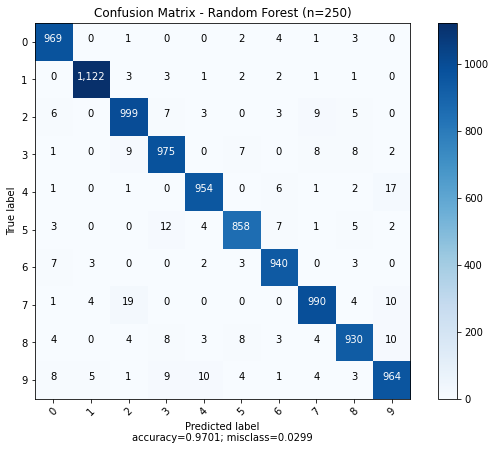

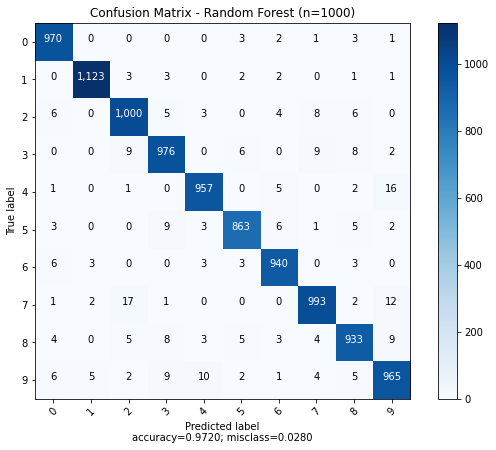

In [ ]:
# Iterate over all forests
for i in n:
  # Create the prediction using the random forest 
  forests_pred = forests[i].predict(x_test_flat)

  # Plot the confusion matrix for the random forest
  cm = tf.math.confusion_matrix(y_test_flat, forests_pred, num_classes=10)
  plot_confusion_matrix(cm=cm.numpy(), target_names=range(10), normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix - Random Forest (n={})'.format(i))

plt.show()

As the `n` in the random forest algorithm increases, the amount of time it takes to train the algorithm exponentially increases. However, the accuracy plateaus around **97%** at `n=100`. It begins to become unreasonable to use an `n` larger than 1,000 as the training time becomes unbearable.

### Model: XGBoost

Similar to Random Forest Classification, [XGBoost](https://xgboost.readthedocs.io/en/latest/) employs an array of decision trees in an attempt to classify inputs. However, XGBoost goes a step further an incorporates complex algorithms, such as graident boosting and regularization, to increase the performance of the model. XGBoost is the more modern approach to this type of classification algorithm and, in theory, will provide better results than that of the Random Forest Classification algorithm.

![](https://i.imgur.com/dO3F1BS.png)

In [ ]:
import xgboost as xgb

In [ ]:
# Create XGBoost matrices for training and testing data
xgb_train = xgb.DMatrix(x_train_flat, label=y_train_flat)
xgb_test = xgb.DMatrix(x_test_flat, label=y_test_flat)

In [ ]:
# Create param dictionary
param = {
    'max_depth': 5,
    'eta': 0.3,
    'silent': 0,
    'objective': 'multi:softmax',
    'num_class': 10
}
xgb_epochs = 500

# Train the model
xgb_model = xgb.train(param, xgb_train, xgb_epochs)

In [ ]:
# Create the XGBoost predictions
xgb_pred = xgb_model.predict(xgb_test)

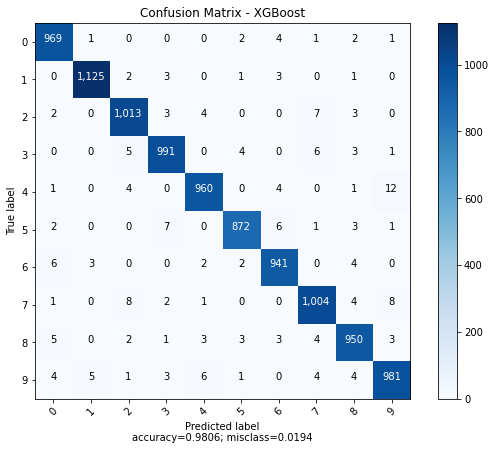

In [ ]:
# Plot the XGBoost confusion matrix
cm = tf.math.confusion_matrix(y_test_flat, xgb_pred, num_classes=10)
plot_confusion_matrix(cm=cm.numpy(), target_names=range(10), normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix - XGBoost')
plt.show()

### Final Thoughts / What's Next?

While elementary, this dataset is a great starter for deep learning and computer vision. This notebook's purpose is to demonstrate how to prepare a dataset as well as how to train existing algorithms using a dataset. While there are thousands of classification algorithms ready to tackle the MNIST dataset, the three discussed in the notebook are a good representation of modern classification algorithms.

Due to the MNIST dataset being exhausted by every machine learning student, there's not much left to do here. Being able to transform existing datasets and apply modern algorithms to the dataset are two important skills to possess. This notebook demonstrates these two skills in an intermediate form.